# Análisis de Evasión de Clientes - Telecom X

Este cuaderno contiene el proceso completo de análisis del churn de clientes para Telecom X, incluyendo ETL, análisis exploratorio de datos, visualizaciones y conclusiones estratégicas.

## Diccionario de Datos

#### Diccionario de datos

- `customerID`: número de identificación único de cada cliente
- `Churn`: si el cliente dejó o no la empresa
- `gender`: género (masculino y femenino)
- `SeniorCitizen`: información sobre si un cliente tiene o no una edad igual o mayor a 65 años
- `Partner`: si el cliente tiene o no una pareja
- `Dependents`: si el cliente tiene o no dependientes
- `tenure`: meses de contrato del cliente
- `PhoneService`: suscripción al servicio telefónico
- `MultipleLines`: suscripción a más de una línea telefónica
- `InternetService`: suscripción a un proveedor de internet
- `OnlineSecurity`: suscripción adicional de seguridad en línea
- `OnlineBackup`: suscripción adicional de respaldo en línea
- `DeviceProtection`: suscripción adicional de protección del dispositivo
- `TechSupport`: suscripción adicional de soporte técnico, menor tiempo de espera
- `StreamingTV`: suscripción de televisión por cable
- `StreamingMovies`: suscripción de streaming de películas
- `Contract`: tipo de contrato
- `PaperlessBilling`: si el cliente prefiere recibir la factura en línea
- `PaymentMethod`: forma de pago
- `Charges.Monthly`: total de todos los servicios del cliente por mes
- `Charges.Total`: total gastado por el cliente

In [3]:
import pandas as pd
import json

# Cargar datos desde archivo
with open("/content/TelecomX_Data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Normalización de los datos anidados
df = pd.json_normalize(data)

# Simplificar nombres de columnas
df.columns = df.columns.str.replace('customer.', '', regex=True)
df.columns = df.columns.str.replace('phone.', '', regex=True)
df.columns = df.columns.str.replace('internet.', '', regex=True)
df.columns = df.columns.str.replace('account.', '', regex=True)
df.columns = df.columns.str.replace('Charges.', '', regex=True)

# Convertir valores a numéricos
df['Total'] = pd.to_numeric(df['Total'], errors='coerce')
df['Monthly'] = pd.to_numeric(df['Monthly'], errors='coerce')
df['Churn'] = df['Churn'].replace({'Sí': 'Yes', 'No': 'No'})
df = df[df['Churn'].isin(['Yes', 'No'])]  # eliminar vacíos

# Crear columna de cuentas diarias
df['Cuentas_Diarias'] = df['Monthly'] / 30

df.head()


/tmp/ipython-input-3029105813.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cuentas_Diarias'] = df['Monthly'] / 30


,D,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Monthly,Total,Cuentas_Diarias
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667


## Limpieza y Tratamiento de Datos
Se realiza limpieza de columnas, conversión de tipos y creación de una nueva variable de análisis `Cuentas_Diarias`.

In [4]:
# Estadísticas generales
df.describe(include='all')

,D,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Monthly,Total,Cuentas_Diarias
count,7043,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043.000000,7032.000000,7043.000000
unique,7043,2,2,NaN,2,2,NaN,2,3,3,...,3,3,3,3,3,2,4,NaN,NaN,NaN
top,9995-HOTOH,No,Male,NaN,No,No,NaN,Yes,No,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,NaN
freq,1,5174,3555,NaN,3641,4933,NaN,6361,3390,3096,...,3095,3473,2810,2785,3875,4171,2365,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2283.300441,2.158723
std,NaN,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2266.771362,1.003002
min,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000,0.608333
25%,NaN,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,401.450000,1.183333
50%,NaN,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1397.475000,2.345000
75%,NaN,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,3794.737500,2.995000


## Visualizaciones Estratégicas

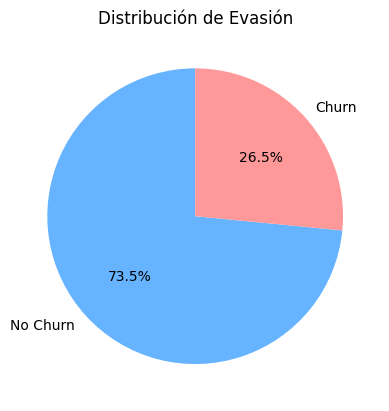

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico: Distribución del churn
df['Churn'].value_counts().plot.pie(autopct='%1.1f%%', labels=['No Churn', 'Churn'], startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Distribución de Evasión')
plt.ylabel('')
plt.show()

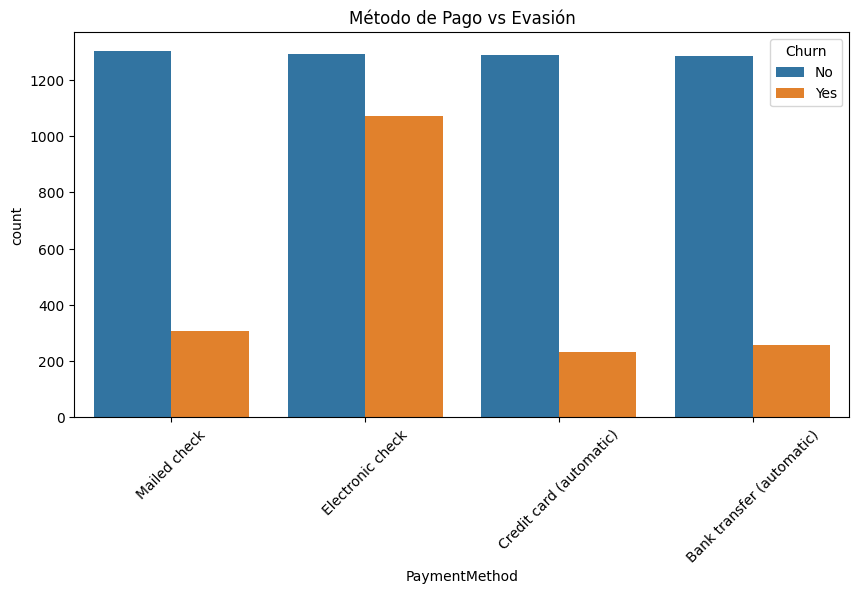

In [6]:
# Gráfico: Método de pago vs churn
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='PaymentMethod', hue='Churn')
plt.title('Método de Pago vs Evasión')
plt.xticks(rotation=45)
plt.show()

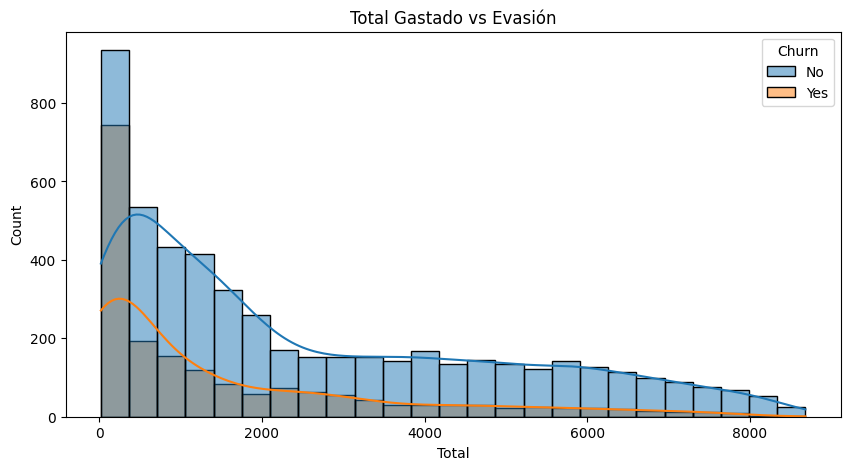

In [7]:
# Gráfico: Total Gastado vs churn
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='Total', hue='Churn', kde=True)
plt.title('Total Gastado vs Evasión')
plt.show()

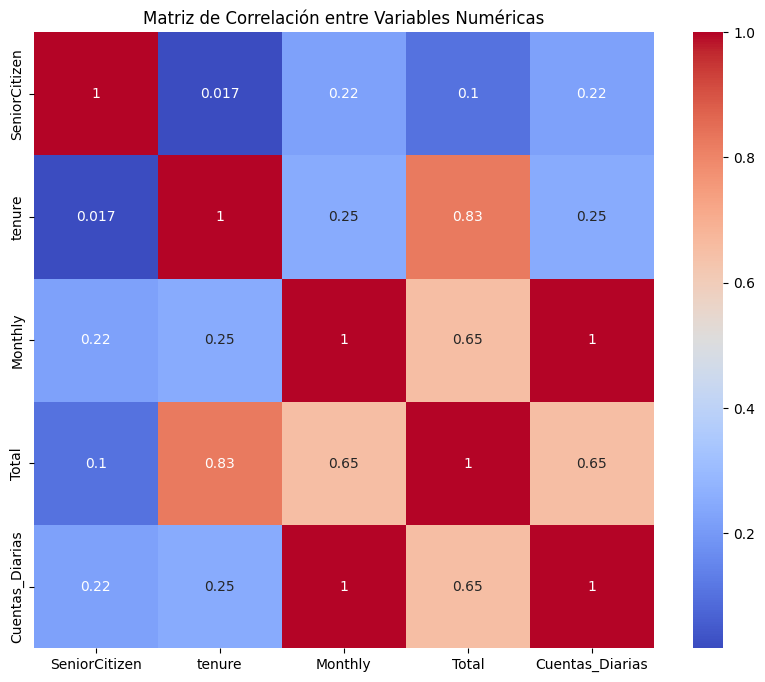

In [8]:
# Matriz de correlación
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación entre Variables Numéricas')
plt.show()

## Conclusiones e Insights

- La mayoría de los clientes permanecen, pero existe un porcentaje significativo de evasión.
- El método de pago `Electronic check` está altamente correlacionado con la evasión.
- Contratos `Month-to-month` presentan mayor churn comparado con contratos anuales o bianuales.
- Clientes con alto gasto mensual también muestran una mayor tasa de abandono.

## Recomendaciones Estratégicas

- Promover contratos anuales o de dos años con beneficios asociados.
- Implementar alertas preventivas a clientes con alto riesgo de churn (alto gasto mensual y pago con `Electronic check`).
- Reforzar campañas de fidelización para usuarios con múltiples servicios.

---